**Goal:**
>Attempt to train model on Real Breast Cancer dataset for prediction of Patient Status (Alive, Dead). Uncover any issues with dataset, train four classification model algorithms on dataset. Evaluate and draw conclusion of model performance with recommendations of model to use for class prediction.  

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, classification_report

%matplotlib inline

In [26]:
brca = pd.read_csv("BRCA.csv")

brca.isnull().sum()


Patient_ID             7
Age                    7
Gender                 7
Protein1               7
Protein2               7
Protein3               7
Protein4               7
Tumour_Stage           7
Histology              7
ER status              7
PR status              7
HER2 status            7
Surgery_type           7
Date_of_Surgery        7
Date_of_Last_Visit    24
Patient_Status        20
dtype: int64

In [27]:
brca.dropna(how='all', inplace=True)
brca.dropna(subset='Patient_Status', inplace = True)

## Exploratory Data Analysis (EDA) ##

In [28]:
brca.info()

<class 'pandas.core.frame.DataFrame'>
Index: 321 entries, 0 to 333
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Patient_ID          321 non-null    object 
 1   Age                 321 non-null    float64
 2   Gender              321 non-null    object 
 3   Protein1            321 non-null    float64
 4   Protein2            321 non-null    float64
 5   Protein3            321 non-null    float64
 6   Protein4            321 non-null    float64
 7   Tumour_Stage        321 non-null    object 
 8   Histology           321 non-null    object 
 9   ER status           321 non-null    object 
 10  PR status           321 non-null    object 
 11  HER2 status         321 non-null    object 
 12  Surgery_type        321 non-null    object 
 13  Date_of_Surgery     321 non-null    object 
 14  Date_of_Last_Visit  317 non-null    object 
 15  Patient_Status      321 non-null    object 
dtypes: float64(5)

In [29]:
brca['Gender'].value_counts()

Gender
FEMALE    317
MALE        4
Name: count, dtype: int64

> Gender as a feature in the model training likely won't be helpful as there is not enough occurrences of male patients

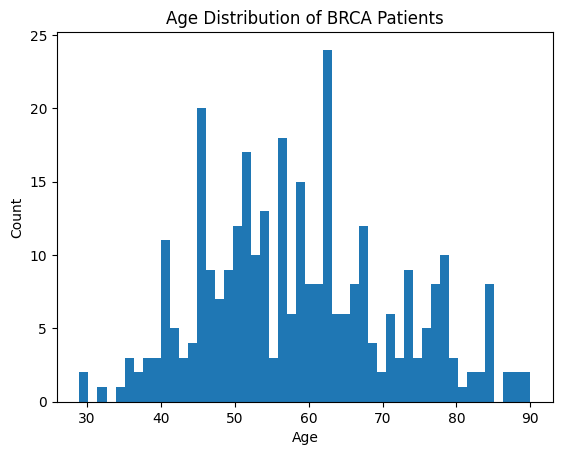

In [30]:
brca['Age'].hist(bins = 50, grid = False)
plt.xlabel(xlabel = "Age")
plt.ylabel(ylabel = "Count")
plt.title("Age Distribution of BRCA Patients")
plt.show()

> Age groups in the dataset appears to be mostly normally distributed, with slight right skewness--most of population is in 45-55 year old age group. 

In [31]:
# Display unique classifications of breast cancer in patients
brca['Histology'].unique()

array(['Infiltrating Ductal Carcinoma', 'Mucinous Carcinoma',
       'Infiltrating Lobular Carcinoma'], dtype=object)

In [32]:
def plot_pie_chart(column, title):
    # define Seaborn color palette to use
    palette_color = sns.color_palette('bright')
  
    # plotting data on chart
    plt.pie(brca[column].value_counts(), labels=brca[column].unique(), colors=palette_color, autopct='%.0f%%')

    plt.title(title)
    # displaying chart
    plt.show()

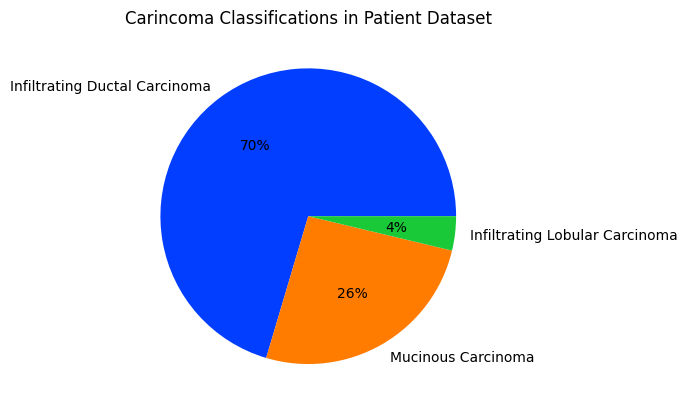

In [33]:
plot_pie_chart("Histology", "Carincoma Classifications in Patient Dataset")

## Invasive ductal carcinoma (IDC) ## 
> Invasive ductal carcinoma (IDC), also known as infiltrating ductal carcinoma, is a type of breast cancer that starts in the milk ducts of the breast and moves into nearby tissue. In time, IDC may spread (metastasize) through the lymph nodes or bloodstream to other areas of the body. [Further Information](https://www.pennmedicine.org/cancer/types-of-cancer/breast-cancer/types-of-breast-cancer/invasive-ductal-carcinoma#:~:text=Invasive%20ductal%20carcinoma%20(IDC)%2C,other%20areas%20of%20the%20body.)   

## Mucinous carcinoma ##
> In mucinous carcinoma, cancer cells form in mucin, the main component of mucus. Mucins are proteins that help with the function of healthy cells. In mucinous carcinoma, the mucin around cancer cells becomes part of the tumor. Mucinous carcinoma can occur anywhere in your body, but it’s most common in your breast. [Further Information](https://my.clevelandclinic.org/health/diseases/22975-mucinous-carcinoma#:~:text=In%20mucinous%20carcinoma%2C%20cancer%20cells,most%20common%20in%20your%20breast.)

## Invasive lobular carcinoma (ILC) ##
> Invasive lobular carcinoma, also known as infiltrating lobular carcinoma, begins in the milk-producing glands (lobules) of the breast. As an invasive type of cancer, ILC has spread beyond its original tumor site. Over time, ILC may become metastatic breast cancer. [Further Information](https://www.pennmedicine.org/cancer/types-of-cancer/breast-cancer/types-of-breast-cancer/invasive-lobular-carcinoma#:~:text=Invasive%20lobular%20carcinoma%2C%20also%20known,may%20become%20metastatic%20breast%20cancer.)

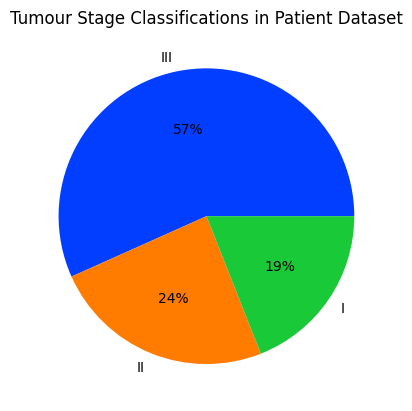

In [34]:
plot_pie_chart("Tumour_Stage", "Tumour Stage Classifications in Patient Dataset")

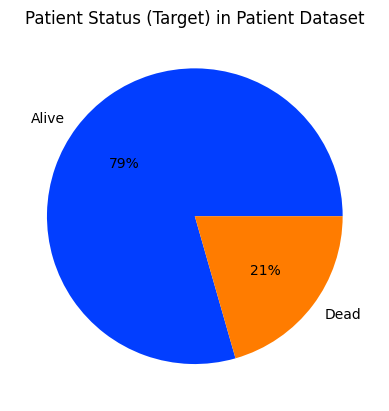

In [35]:
# Identify target feature for model prediction, two classes
plot_pie_chart("Patient_Status", "Patient Status (Target) in Patient Dataset")

> We identify that the dataset for our target is fairly unbalanced towards patients that are alive. This would make it difficult to properly make classifications without resampling the dataset. 

## Preprocessing/Feature Engineering ##

In [36]:
# Make copy of original dataset and drop uninformative features
brca_processed = brca.copy().drop(columns=['Patient_ID', 'Surgery_type', 'Gender', 'ER status', 'PR status'])
# Label Encode target feature to integer for classification
le = LabelEncoder()
brca_processed['Patient_Status_le'], brca_processed['HER2_Status_le'] = le.fit_transform(brca_processed['Patient_Status']), le.fit_transform(brca_processed['HER2 status'])


In [37]:
# Ordinal encode Tumour stages from dataset categorical -> numeric
oe = OrdinalEncoder(dtype=int)
brca_processed['Tumour_Stage_oe'] = oe.fit_transform(np.array(brca_processed['Tumour_Stage']).reshape(-1,1))
brca_processed.drop(columns=['Tumour_Stage', 'Date_of_Surgery', 'Date_of_Last_Visit'], inplace=True)

In [38]:
brca_processed = pd.get_dummies(brca_processed, columns=['Histology'], dtype = int)

In [39]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(brca_processed.drop(columns=['Patient_Status', 'Patient_Status_le', 'HER2 status']), brca_processed['Patient_Status_le'], test_size = 0.20, random_state = 42, stratify=brca_processed['Patient_Status_le'])

# ## Resample dataset so that target feature is evenly distributed
oversample = SMOTE(n_jobs=100, random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)


c:\Users\james\anaconda3\envs\data\lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


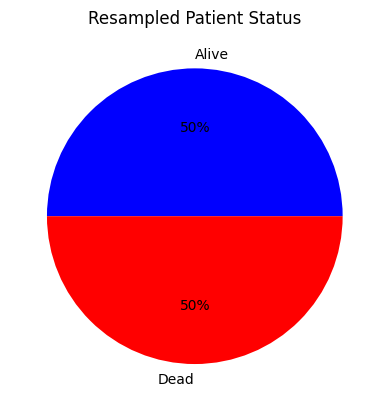

In [40]:
# plotting data on chart
plt.pie(y_train.value_counts(), labels=brca_processed['Patient_Status'].unique(), colors='bright', autopct='%.0f%%')

plt.title("Resampled Patient Status")
# displaying chart
plt.show()

## Support Vector Classification (SVC) ##

In [41]:
svc = SVC(probability=True)
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
clf = GridSearchCV(svc, parameters, n_jobs=50)
clf.fit(X_train, y_train)
GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 100], 'kernel': ('linear', 'rbf')})
clf.best_estimator_

SVC(C=1, kernel='linear', probability=True)

> Best estimator chosen during the fitting/GridSearch shows hyperparameters for the model  

## Logistic Regression ##

c:\Users\james\anaconda3\envs\data\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


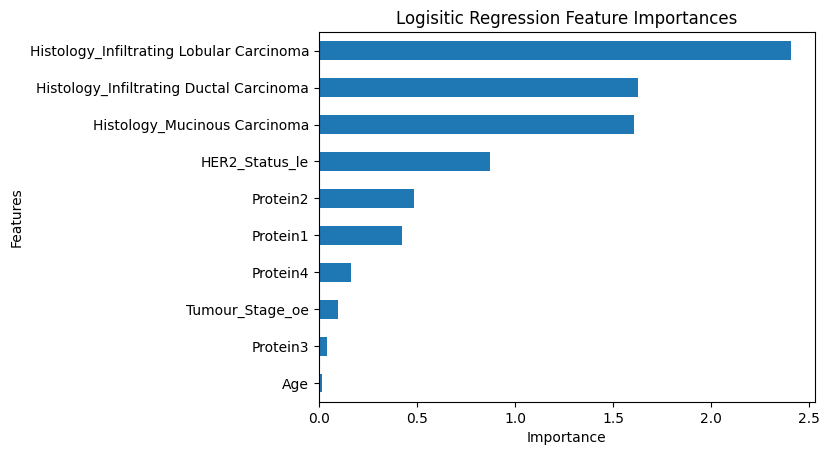

In [42]:
logit = LogisticRegression(max_iter=3500, penalty='elasticnet', solver = 'saga', l1_ratio=1)
logit.fit(X_train, y_train)
logit_importances = logit.coef_[0]
logit_feature_importances = pd.Series(index = X_train.columns, data= np.abs(logit_importances))
logit_feature_importances = logit_feature_importances.sort_values(ascending=True)
logit_feature_importances.plot(kind='barh', title = 'Logisitic Regression Feature Importances', xlabel = 'Importance', ylabel = 'Features')
plt.show()

> Following training of the Logisitic Regression model on the dataset, the most important features that contribute to classification of Patient Status include <b>Histology of ILC, IDC carcinomas and patient is HER2+/-</b>. Features that don't seem to contribute to the model's prediction include <b>age</b>, <b>stage of tumour</b>. Suprisingly, the stage of a tumour does not seem to contribute much informationally to the model, despite domain knowledge of this feature. This may be due to skewness of the data towards stage III cancer as this is prevalent in ~60% of the patients in the dataset. HER2 status also is a informative input feature for the model as we understand by HER2++ typically as a predictor of cancer cases. 

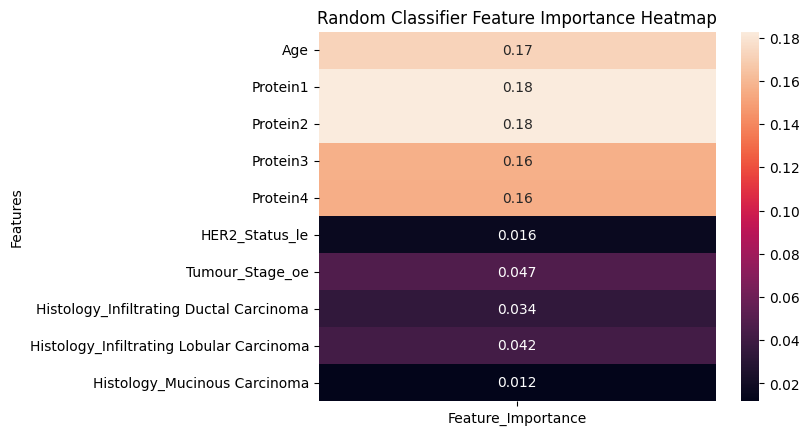

In [43]:
forest = RandomForestClassifier(n_estimators=1500)
forest.fit(X_train, y_train)
forest_feature_importance = pd.DataFrame(index = forest.feature_names_in_, data=forest.feature_importances_, columns = ['Feature_Importance'])
sns.heatmap(forest_feature_importance, annot=True).set(title = "Random Classifier Feature Importance Heatmap", ylabel='Features')
plt.show()

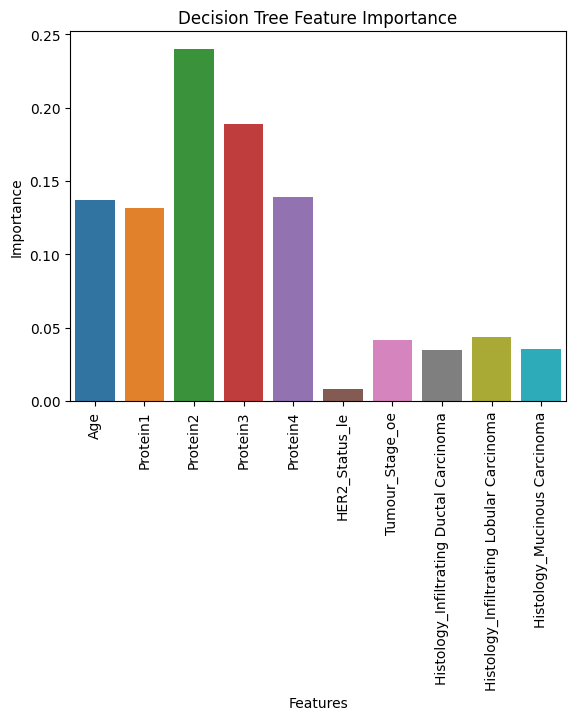

In [44]:
tree_gini = DecisionTreeClassifier(criterion='gini', max_depth=15)
tree_gini.fit(X_train, y_train)
tree_gini_feature_importances = pd.Series(tree_gini.feature_importances_, index=tree_gini.feature_names_in_)

sns.barplot(x = tree_gini.feature_names_in_, y = tree_gini.feature_importances_).set(title = "Decision Tree Feature Importance", xlabel='Features', ylabel='Importance')
plt.xticks(rotation = 90) 
plt.show()

> Both decision tree classifiers (Decision Tree and Random Forest) produce similar rankings for the importance of the features in the models. <b>Protein 2 expression levels</b> seems to be a driving factor to the classification of patient status, with the other proteins also contributing to the predictions of the model. Opposing to what previously was found from our Logistic Regressor training is that <b>age</b> also contributes to the predictions of the model--this matches to preconceived notion that age also can be a determinant of the patient's outcome with the disease. Interestingly, the lowest scored features for importance are presence of specific carcinoma's <b>(ILC, IDC, MC), HER2 status and stage of the tumour</b>.  

In [45]:
def plot_ROC(model, title, X, Y): 
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_true=Y, y_score=model.predict_proba(X)[:, 1])
    roc_auc = roc_auc_score(y_true=Y, y_score=model.predict_proba(X)[:, 1])
    plt.plot(fpr, tpr, color="blue", label="AUC = %0.3f" % roc_auc)
    plt.plot([0, 1], [0, 1], color="red", linestyle="--", lw=1)
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

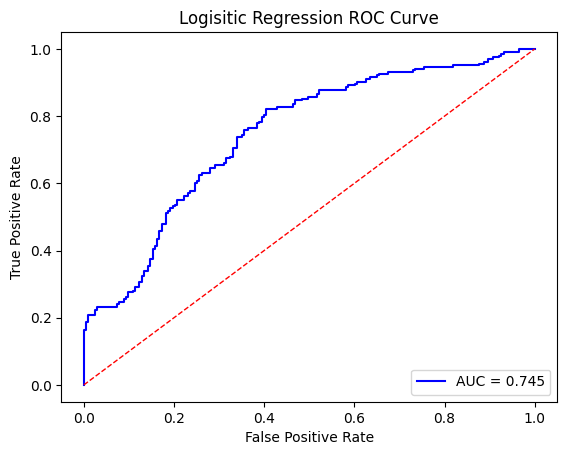

Accuracy Score: 0.6773399014778325
Confusion Matrix:
 [[136  67]
 [ 64 139]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.67      0.67       203
           1       0.67      0.68      0.68       203

    accuracy                           0.68       406
   macro avg       0.68      0.68      0.68       406
weighted avg       0.68      0.68      0.68       406



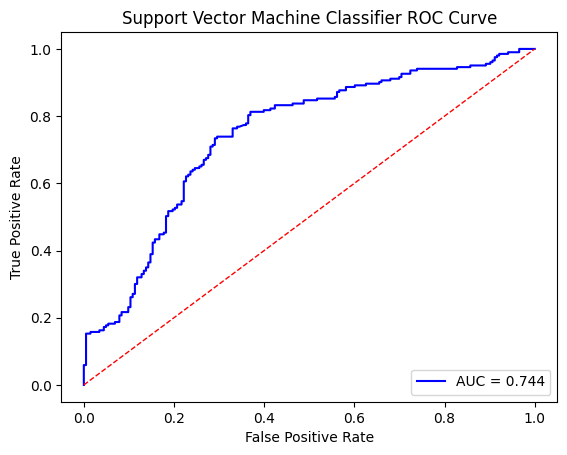

Accuracy Score: 0.7192118226600985
Confusion Matrix:
 [[128  75]
 [ 39 164]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.63      0.69       203
           1       0.69      0.81      0.74       203

    accuracy                           0.72       406
   macro avg       0.73      0.72      0.72       406
weighted avg       0.73      0.72      0.72       406



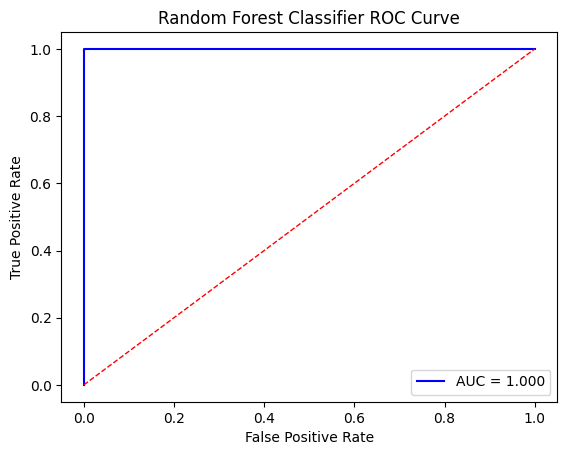

Accuracy Score: 1.0
Confusion Matrix:
 [[203   0]
 [  0 203]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       203
           1       1.00      1.00      1.00       203

    accuracy                           1.00       406
   macro avg       1.00      1.00      1.00       406
weighted avg       1.00      1.00      1.00       406



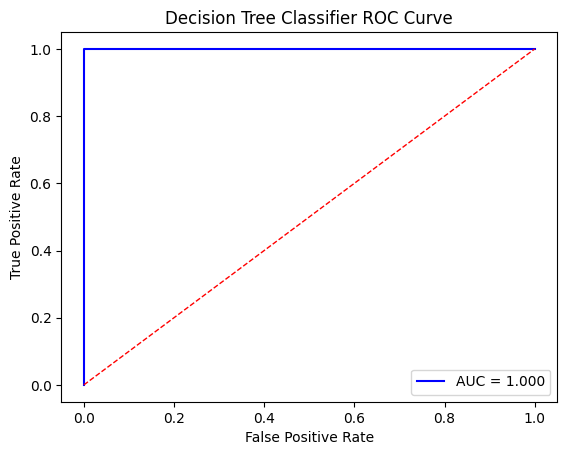

Accuracy Score: 1.0
Confusion Matrix:
 [[203   0]
 [  0 203]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       203
           1       1.00      1.00      1.00       203

    accuracy                           1.00       406
   macro avg       1.00      1.00      1.00       406
weighted avg       1.00      1.00      1.00       406



In [46]:
# Performance on training data
plot_ROC(logit, "Logisitic Regression ROC Curve", X_train, y_train)
print(f"Accuracy Score: {accuracy_score(y_true=y_train, y_pred=logit.predict(X_train))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_train, y_pred=logit.predict(X_train))}")
print(f"Classification Report:\n {classification_report(y_true=y_train, y_pred=logit.predict(X_train))}")

plot_ROC(clf, "Support Vector Machine Classifier ROC Curve", X_train, y_train)
print(f"Accuracy Score: {accuracy_score(y_true=y_train, y_pred=clf.predict(X_train))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_train, y_pred=clf.predict(X_train))}")
print(f"Classification Report:\n {classification_report(y_true=y_train, y_pred=clf.predict(X_train))}")

plot_ROC(forest, "Random Forest Classifier ROC Curve", X_train, y_train)
print(f"Accuracy Score: {accuracy_score(y_true=y_train, y_pred=forest.predict(X_train))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_train, y_pred=forest.predict(X_train))}")
print(f"Classification Report:\n {classification_report(y_true=y_train, y_pred=forest.predict(X_train))}")

plot_ROC(tree_gini, "Decision Tree Classifier ROC Curve", X_train, y_train)
print(f"Accuracy Score: {accuracy_score(y_true=y_train, y_pred=tree_gini.predict(X_train))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_train, y_pred=tree_gini.predict(X_train))}")
print(f"Classification Report:\n {classification_report(y_true=y_train, y_pred=tree_gini.predict(X_train))}")


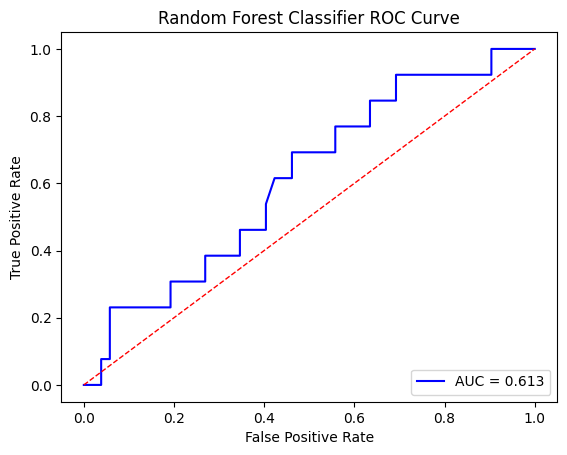

Accuracy Score: 0.6923076923076923
Confusion Matrix:
 [[41 11]
 [ 9  4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.80        52
           1       0.27      0.31      0.29        13

    accuracy                           0.69        65
   macro avg       0.54      0.55      0.54        65
weighted avg       0.71      0.69      0.70        65



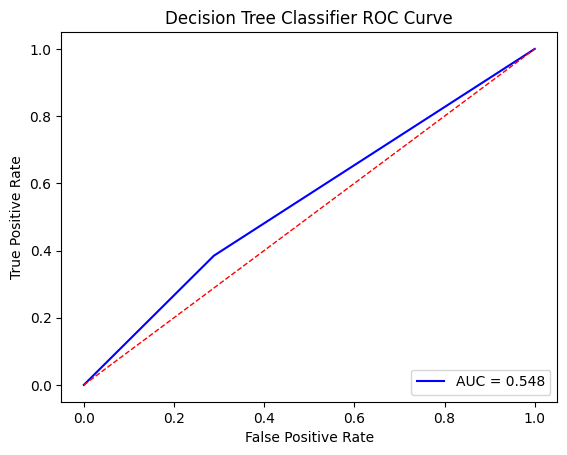

Accuracy Score: 0.6461538461538462
Confusion Matrix:
 [[37 15]
 [ 8  5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.71      0.76        52
           1       0.25      0.38      0.30        13

    accuracy                           0.65        65
   macro avg       0.54      0.55      0.53        65
weighted avg       0.71      0.65      0.67        65



In [47]:
plot_ROC(forest, "Random Forest Classifier ROC Curve", X_test, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=forest.predict(X_test))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=forest.predict(X_test))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=forest.predict(X_test))}")

plot_ROC(tree_gini, "Decision Tree Classifier ROC Curve", X_test, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=tree_gini.predict(X_test))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=tree_gini.predict(X_test))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=tree_gini.predict(X_test))}")


**Discussion:** 

*Data Processing/Feature Engineering*
>Evaluating this dataset, we came encountered a few challenges with attempting to train an accurate model for Patient Status prediction. Firstly, seven rows of the original CSV contained all NaN values with an additional 13 rows of the target column also including NaN (patients that no record of status had been verified). As part of the analysis, we chose to drop these values as they brought no value to our overall training/prediction. Secondly, we notice that the dataset for our target column was heavily imbalanced towards patients that lived, with ~80% of the original dataset for patients that live from the disease (tremendous for those patients, challenging for analysis/model training). Due to this, we decided to oversample the patients that died from the disease as a way of attempting to even the distribution. With additional data preprocessing/feature engineering to encode each of the features from categorical to numeric values (eg. HER2 status and Tumour Stage). Following processing and feature engineering of the dataset, we split this into a training and testing set (80:20 split).

*Model Evaluation*
>In total, four different model algorithms were trained on the breast cancer dataset (Support Vector Machine Classifier, Logistic Regression, Random Forest Classifier, Decision Tree Classifier) for binary classification of the patient status target. Above we display Receiver Operating Characteristic plots of the models performance (Area Under the Curve, AUC) with the training/test datasets for predicting patient status with accuracy score, the confusion matrix and classification report. 

>SVC and Logistic Regression model algorithms look to be underfitting during the training. Re-testing our model predictions on the same dataset used for training, we see errors in the predictions with several false negatives/positives. Poor performance on the training data could be because the models are too simple which could be we need to adjust our hyperparameters of the model (regularization, n_jobs, adding new domain-specific features) to improve performance.

>Random Forest and Decision Tree classifiers both perform very well on the training data, with 100% accuracy of the target classes. With this result, we chose to move forward with evaluating these models for prediction of test data.

>AUC scores of the Random Forest ~0.6 (shown in blue above) and Decision Tree classifiers is ~0.55. The models really only to give a slight benefit of predicting a patient's status compared to randomly guessing the patient's outcome (equivalent to AUC score of 0.5). Additionally, the accuracy scores for these models range from ~70%. Looking at the confusion matrices/classification report for the models, we see that for all of them there is quite a high false positive rate, specifically for classifying the patient to die from the disease (class 1). Precision, recall and F1-scores for each of the model's is fairly low for prediction of this class.  
   